# Resampling Methods

The goal of this project is to Apply Cross Validation and Bootstrap method to the [regression](https://github.com/komus/business_analytics/blob/master/regression/assignmenta01.ipynb) and [classification](https://github.com/komus/business_analytics/blob/master/classification/assignment02.ipynb) model done previously

In [176]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc,balanced_accuracy_score, roc_curve,precision_score,recall_score
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.utils import resample
import warnings

warnings.filterwarnings("ignore")

# Data

The data to be used for this project is exported from previous project after EDA and feature Engineering. 

In [177]:
bank_data = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/classification/bank_data.csv", index_col = 0)
diamond_data = pd.read_csv("https://raw.githubusercontent.com/komus/business_analytics/master/regression/diamond_data.csv", index_col=0)

RANDOM_STATE = 100

# Regression

The diamond data will be used for regression. The evaluation metric is R-Squared

In [178]:
diamond_features = diamond_data.drop(columns='Price')
diamond_target = diamond_data['Price']
folds = KFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)

## Cross Validation

All the 10 features are used in LinearRegression with cross validation of 10. Cross validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The 10 folds run gave a mean r-squared value of `0.922` and `0.917` for Linear Regression and Ridge respectively.

In [179]:
model_lr = LinearRegression()
scores_lr = cross_validate(model_lr, diamond_features, diamond_target, scoring='r2', cv = folds, return_train_score=True)

In [180]:
scores_lr

{'fit_time': array([0.00498581, 0.00299287, 0.00398993, 0.00199413, 0.00299358,
        0.00296211, 0.00202727, 0.00200057, 0.0009954 , 0.00196457]),
 'score_time': array([0.00299215, 0.00199461, 0.00199533, 0.0009973 , 0.00199461,
        0.00199127, 0.00099659, 0.00099778, 0.00396156, 0.00099587]),
 'test_score': array([0.94632331, 0.93687415, 0.94380597, 0.9127746 , 0.90346905,
        0.93895214, 0.84363613, 0.92225336, 0.95923249, 0.91794495]),
 'train_score': array([0.927849  , 0.92742823, 0.92773343, 0.93175639, 0.93232141,
        0.92827384, 0.93708654, 0.92992394, 0.92671597, 0.93095837])}

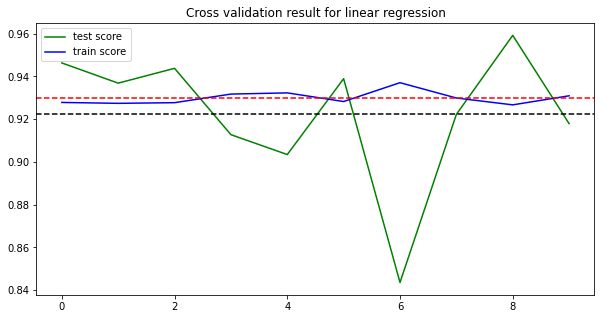

In [181]:
plt.figure(figsize=(10,5))
plt.plot( scores_lr['test_score'],  color='green', label = 'test score' )
plt.plot( scores_lr['train_score'], color='blue', label = 'train score')
plt.axhline(scores_lr['test_score'].mean(), color='black', ls='--')
plt.axhline(scores_lr['train_score'].mean(), color='red', ls='--')
plt.title("Cross validation result for linear regression")
plt.legend();

In [182]:
scores_lr['test_score'].mean()

0.9225266152598991

In [183]:
rst = {
    "model": "CV Linear Regression",
    "R_squared test": scores_lr['test_score'].mean()
}
result = pd.DataFrame(rst, index = [1])

Using Ridge for regression introduces the l2 penalty

In [184]:
model_r = Ridge(random_state=RANDOM_STATE)
scores_r = cross_validate(model_r, diamond_features, diamond_target, scoring='r2', cv = folds, return_train_score=True)

In [185]:
scores_r

{'fit_time': array([0.00299191, 0.00199533, 0.00199533, 0.00199389, 0.00199366,
        0.00199342, 0.00199389, 0.00199366, 0.00399089, 0.00199461]),
 'score_time': array([0.00299096, 0.00099635, 0.00099707, 0.0009985 , 0.00199485,
        0.00099707, 0.00199389, 0.00199437, 0.00199366, 0.00199437]),
 'test_score': array([0.93644522, 0.91294856, 0.92515771, 0.90986391, 0.89690741,
        0.92758054, 0.86155734, 0.92339096, 0.96193267, 0.90985817]),
 'train_score': array([0.92204708, 0.92127507, 0.92185418, 0.92563343, 0.9263614 ,
        0.92251178, 0.93078706, 0.92384504, 0.92066028, 0.92500623])}

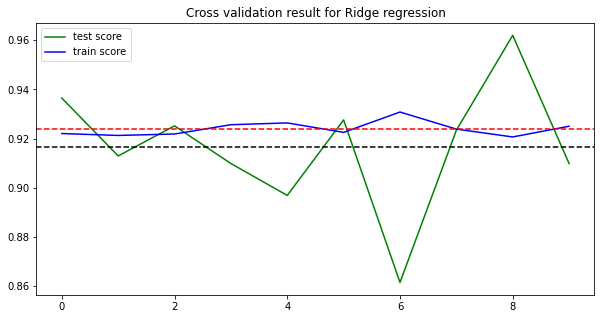

In [186]:
plt.figure(figsize=(10,5))
plt.plot( scores_r['test_score'],  color='green', label = 'test score' )
plt.plot( scores_r['train_score'], color='blue', label = 'train score')
plt.axhline(scores_r['test_score'].mean(), color='black', ls='--')
plt.axhline(scores_r['train_score'].mean(), color='red', ls='--')
plt.title("Cross validation result for Ridge regression")
plt.legend();

In [187]:
scores_r['test_score'].mean()

0.9165642477837643

In [188]:
rst = {
    "model": "CV Ridge",
    "R_squared test": scores_r['test_score'].mean()
}
result = result.append(rst, ignore_index = True)

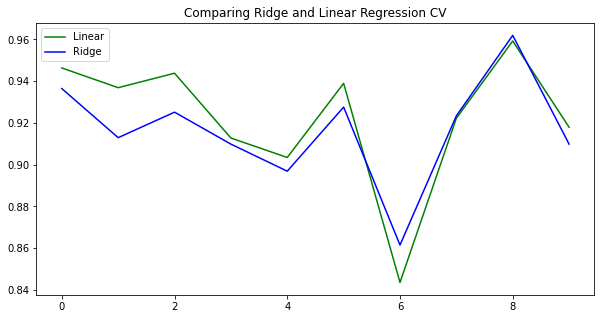

In [189]:
plt.figure(figsize=(10,5))
plt.plot( scores_lr['test_score'],  color='green', label = 'Linear' )
plt.plot( scores_r['test_score'], color='blue', label = 'Ridge')
plt.title("Comparing Ridge and Linear Regression CV")
plt.legend();

## Bootstraping

Using bootstraping method for 10 iterations, the average r-squared for Linear Regression and Ridge is `0.923` and `0.92` respectively

In [190]:
n_iterations = 10

In [191]:
def bootstrap(data, model):
    rst = []
    for i in range(n_iterations):
        train = resample(data, replace=True, n_samples=len(data))
        test = data[~data.index.isin(train.index)]

        x_train = train.iloc[:, 0:-1]
        y_train = train.iloc[:, -1]

        x_test = test.iloc[:, 0:-1]
        y_test = test.iloc[:, -1]

        model.fit(x_train, y_train)
        r_squared = model.score(x_test, y_test)
        rst.append(r_squared)
    return rst

In [192]:
boot_lr = bootstrap(diamond_data, model_lr)
boot_r = bootstrap(diamond_data, model_r)

In [193]:
boot_rst = pd.DataFrame(list(zip(boot_lr, boot_r)),
               columns =['Linear Regression', 'Ridge'])
boot_rst

,Linear Regression,Ridge
0,0.929196,0.914546
1,0.923803,0.899265
2,0.920538,0.917070
3,0.916776,0.936578
4,0.939722,0.918354
5,0.911073,0.923066
6,0.923816,0.920105
7,0.933133,0.923487
8,0.911272,0.938602
9,0.916801,0.904713


In [194]:
rst = {
    "model": "Bootstrap Linear Regression",
    "R_squared test": boot_rst['Linear Regression'].mean()
}
result = result.append(rst, ignore_index = True)

In [195]:
rst = {
    "model": "Bootstrap Ridge",
    "R_squared test": boot_rst['Ridge'].mean()
}
result = result.append(rst, ignore_index = True)
result

,model,R_squared test
0,CV Linear Regression,0.922527
1,CV Ridge,0.916564
2,Bootstrap Linear Regression,0.922613
3,Bootstrap Ridge,0.919578


## Regression Conclusion

The results generated by cross validation and bootstraping are relatively similar

# Classication